In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time
import numpy as np
import matplotlib.pyplot as plt

# 设置中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

## 生成实验数据

In [17]:
import torch
import torch.utils.data as data
import numpy as np

# 设置随机种子以确保结果可重复性
torch.manual_seed(42)

# 数据集大小
total_samples = 10000
train_samples = 7000
test_samples = 3000

# 样本特征维度
feature_dim = 200

# # 生成两个正态分布的数据集
# mean1 = np.random.randn(feature_dim)
# mean2 = -mean1
# covariance = np.identity(feature_dim)  # 方差相同，协方差矩阵为单位阵

# data1 = np.random.multivariate_normal(mean1, covariance, total_samples)
# data2 = np.random.multivariate_normal(mean2, covariance, total_samples)

# 指定均值和方差
mean = 1
std = 2

# 生成正态分布数据
data1 = np.random.normal(mean, std, size=(total_samples, feature_dim))
data2 = np.random.normal(-mean, std, size=(total_samples, feature_dim))

# 构造标签
labels1 = np.zeros(total_samples)
labels2 = np.ones(total_samples)

# 分开构建训练集和测试集
train_features = torch.tensor(np.vstack((data1[:train_samples], data2[:train_samples])))
train_labels = torch.tensor(np.concatenate((labels1[:train_samples], labels2[:train_samples])))

test_features = torch.tensor(np.vstack((data1[train_samples:], data2[train_samples:])))
test_labels = torch.tensor(np.concatenate((labels1[train_samples:], labels2[train_samples:])))

# 构建Dataset类
class CustomDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels.long()
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

# 划分训练集和测试集
train_dataset = CustomDataset(train_features, train_labels)
test_dataset = CustomDataset(test_features, test_labels)

# 创建数据加载器
batch_size = 32

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 检查数据加载器的样本数量
print(f"Train loader size: {len(train_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")


Train loader size: 14000
Test loader size: 6000


In [18]:
# 定义画图函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(dpi=100)
    x = np.arange(len(train_loss)) 
    plt.plot(x, train_loss, label='train', color='red', linewidth=1)
    plt.plot(x, test_loss, label='test', color='blue', linewidth=1)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# 计算模型评估的准确率
def evaluate(model, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(torch.float32)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

## 1. 手动实现前馈神经网络解决二分类问题

### 1.1 手动构建神经网络模型

In [33]:
import numpy as np
class FeedForwardNN:
    def __init__(self, input_dim, hidden_dim, output_dim):

        W1 = torch.tensor(np.random.normal(0,0.01,(input_dim, hidden_dim)), dtype=torch.float)
        b1 = torch.zeros(hidden_dim, dtype=torch.float)
        W2 = torch.tensor(np.random.normal(0,0.01,(hidden_dim, output_dim)), dtype=torch.float)
        b2 = torch.zeros(output_dim, dtype=torch.float)
        
        self.params = [W1, b1, W2, b2]
        for param in self.params:
            param.requires_grad = True

    # 定义Relu激活函数
    def MyRelu(self, X):
        return torch.max(torch.zeros_like(X), X)
    
    # 手动实现前向传播
    def forward(self, X):
        hidden_output = self.MyRelu(torch.matmul(X, self.params[0]) + self.params[1])
        output = torch.matmul(hidden_output, self.params[2]) + self.params[3]
        
        return output

# # 定义损失函数
# def cross_entropy_loss(y_pred, y_true):
#         m = y_true.shape[0]
#         log_probs = -torch.log(y_pred[range(m), y_true])
#         loss = torch.sum(log_probs) / m
#         return loss

# 交叉熵损失（PPT实现方式）
cross_entropy_loss = lambda y_hat, y: (- torch.log(y_hat.gather(1, y.view(-1, 1)))).mean()

# 手动实现随机梯度下降算法
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

# 定义模型训练函数
def train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs, lr, device):
    start_time = time.time()  # 记录训练开始时间
    train_loss_values = []
    test_loss_values = []

    for epoch in range(num_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(torch.float32)   # 保证输入数据和模型权重的类型一致
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播
            outputs = model.forward(inputs)
            # 计算损失
            loss = loss_function(outputs, labels)
            # 反向传播，对参数求导
            loss.backward()
            # 更新参数
            optimizer(model.params, lr)
            # 清除参数梯度
            for param in model.params:
                param.grad.data.zero_()
            # 累加训练损失
            training_loss += loss.item()
        # 对训练损失求均值作为本次epoch的训练损失
        training_loss = training_loss / len(train_loader)
        train_loss_values.append(training_loss)

        # 测试循环
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(torch.float32)
                inputs, labels = inputs.to(device), labels.to(device)
                # 前向传播
                outputs = model.forward(inputs)
                # 计算损失
                loss = loss_function(outputs, labels)
                testing_loss += loss.item()

            testing_loss = testing_loss / len(test_loader)
            test_loss_values.append(testing_loss)
           
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {training_loss:.4f}, Testing Loss: {testing_loss:.4f}")

    end_time = time.time()  # 记录训练结束时间
    total_time = end_time - start_time
    print("\n总训练时间：%.2f秒" % total_time)

    return train_loss_values, test_loss_values

### 1.2 定义超参数、损失、优化函数，训练神经网络

In [34]:
# 定义模型超参数
input_dim = 200
hidden_dim = 64
output_dim = 2
learning_rate = 0.001
num_epochs = 10

# define model
model = FeedForwardNN(input_dim, hidden_dim, output_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training the model
train_losses, test_losses = train_model(model, train_loader, test_loader, cross_entropy_loss, SGD, num_epochs, learning_rate, device)

Epoch [1/10], Training Loss: nan, Testing Loss: -1.8534
Epoch [2/10], Training Loss: -2.2172, Testing Loss: -2.5171
Epoch [3/10], Training Loss: -2.7255, Testing Loss: -2.9151
Epoch [4/10], Training Loss: -3.0608, Testing Loss: -3.2000
Epoch [5/10], Training Loss: -3.3118, Testing Loss: -3.4219
Epoch [6/10], Training Loss: -3.5124, Testing Loss: -3.6037
Epoch [7/10], Training Loss: -3.6794, Testing Loss: -3.7576
Epoch [8/10], Training Loss: -3.8226, Testing Loss: -3.8910
Epoch [9/10], Training Loss: -3.9479, Testing Loss: -4.0088
Epoch [10/10], Training Loss: -4.0593, Testing Loss: -4.1143

总训练时间：2.93秒


In [37]:
# 计算模型评估的准确率
def evaluate(model, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(torch.float32)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# 在训练集和测试集上进行评估
train_accuracy = evaluate(model, train_loader, device)
test_accuracy = evaluate(model, test_loader, device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 1.0000
Test Accuracy: 1.0000


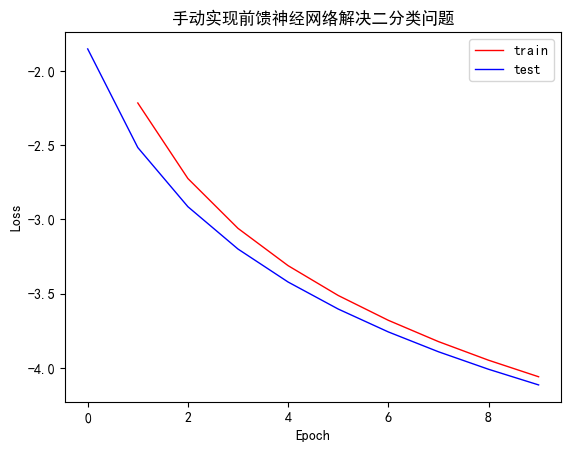

In [36]:
plot_loss(train_losses, test_losses, title="手动实现前馈神经网络解决二分类问题")

### 1.3 实验结果分析

#### 训练时间
在该回归任务中，训练时间为2.9秒，模型的训练速度较快

#### 预测精度
因为是分类任务，采用模型的分类准确率作为评价指标，训练集和测试集的准确率均为1，可见模型能够对输入数据预测的非常准确

#### Loss变化情况
从上图可以看出，Loss值均为负数，应该是模型过拟合，哭了，改了好久代码，数据改了，损失函数改了，训练过程的函数也改了，损失值还是异常，尽力了，还在努力找解决措施中...助教大大看到了麻烦给个辛苦分（大哭）

## 2. 基于PyTorch实现前馈神经网路解决二分类问题

### 2.1 基于PyTorch构建网络模型和训练函数

In [76]:
# 构造神经网络模型的类
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(FeedForwardNN, self).__init__()
        # 定义神经网络的层和结构
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        # 定义前向传播的逻辑
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# 模型训练函数
def train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs, device):
    start_time = time.time()  # 记录训练开始时间
    train_loss_values = []
    test_loss_values = []

    for epoch in range(num_epochs):
        training_loss = 0.0
        testing_loss = 0.0

        # 切换到训练模式
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播
            outputs = model(inputs)
            # 计算损失
            loss = loss_function(outputs, labels)
            # 反向传播，对参数求导
            loss.backward()
            # 更新参数
            optimizer.step()
            # 清除参数梯度
            optimizer.zero_grad()
            training_loss += loss.item()
        
        training_loss = training_loss / len(train_loader)
        train_loss_values.append(training_loss)

        # 测试循环
        with torch.no_grad():
            model.eval()  # 将模型切换为测试模式
            for inputs, labels in test_loader:
                inputs = inputs.to(torch.float32)
                inputs, labels = inputs.to(device), labels.to(device)
                # 前向传播
                outputs = model(inputs)
                # 计算损失
                loss = loss_function(outputs, labels)
                testing_loss += loss.item()

            testing_loss = testing_loss / len(test_loader)
            test_loss_values.append(testing_loss)
            
        # if (epoch+1) % 2 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {training_loss:.4f}, Testing Loss: {testing_loss:.4f}")

    end_time = time.time()  # 记录训练结束时间
    total_time = end_time - start_time
    print("\n总训练时间：%.2f秒" % total_time)

    return train_loss_values, test_loss_values

### 2.2 定义超参数、损失、优化器，训练模型

In [77]:
# 初始化超参数和模型
input_dim = 200
hidden_dim1 = 64
hidden_dim2 = 32
output_dim = 2
num_epochs = 10
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNN(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)

# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 训练模型
train_loss_values, test_loss_values = train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs, device)


Epoch [1/10], Training Loss: 0.5018, Testing Loss: 0.2938
Epoch [2/10], Training Loss: 0.1549, Testing Loss: 0.0714
Epoch [3/10], Training Loss: 0.0446, Testing Loss: 0.0280
Epoch [4/10], Training Loss: 0.0207, Testing Loss: 0.0155
Epoch [5/10], Training Loss: 0.0125, Testing Loss: 0.0101
Epoch [6/10], Training Loss: 0.0086, Testing Loss: 0.0073
Epoch [7/10], Training Loss: 0.0064, Testing Loss: 0.0057
Epoch [8/10], Training Loss: 0.0050, Testing Loss: 0.0045
Epoch [9/10], Training Loss: 0.0041, Testing Loss: 0.0038
Epoch [10/10], Training Loss: 0.0035, Testing Loss: 0.0032

总训练时间：3.48秒


In [86]:
# 在训练集和测试集上进行评估
train_accuracy = evaluate(model, train_loader, device)
test_accuracy = evaluate(model, test_loader, device)

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 1.0000
Test Accuracy: 1.0000


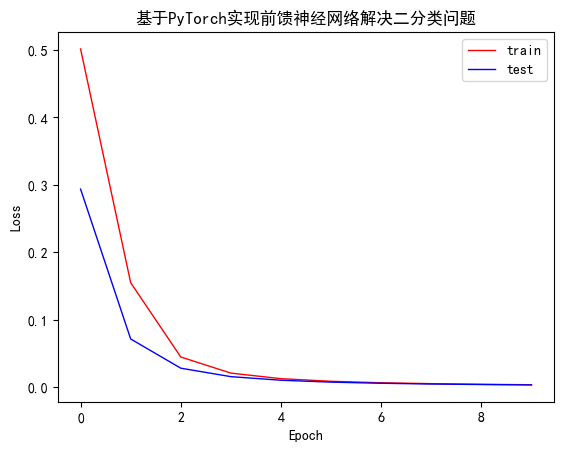

In [78]:
plot_loss(train_loss_values, test_loss_values, title="基于PyTorch实现前馈神经网络解决二分类问题")

### 2.3 实验结果分析

#### 训练时间
在该回归任务中，训练时间为3.48秒，对比可知在同样的模型参数量下，基于PyTorch实现的模型训练速度要比手动实现快，且两种模型训练时间都较短，因为模型结构较为单一

#### 预测精度
因为是分类任务，采用模型的分类准确率作为评价指标，训练集和测试集的准确率均为1，可见模型训练的非常完全，能够对输入数据预测的非常准确

#### Loss变化情况
从上图可以看出，Loss值大约在第三次之后就接近为0,下降的很快，模型训练速度较快，参数更新优化的速度也很快